# Tree-based classifier models

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

# Individual decision trees
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
# Ensemble methods of decision trees
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
# Gradient boosted decision trees
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
# Other methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import IsolationForest
# Advanced boosting methods
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier

# Load pre-trained embeddings
import gensim.downloader as api
glove_vectors = api.load("glove-wiki-gigaword-300")

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer

2025-03-23 02:08:59.870285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742666939.888506   45671 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742666939.893621   45671 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 02:08:59.911655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Check GPU

In [3]:
# Check if TensorFlow can see GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# More detailed GPU information
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU name:", gpu.name)
        print("GPU details:", tf.config.experimental.get_device_details(gpu))
else:
    print("No GPU detected. TensorFlow is running on CPU.")

# Simple test to confirm GPU operation
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("Executed on GPU")

TensorFlow version: 2.18.0
Num GPUs Available: 1
GPU name: /physical_device:GPU:0
GPU details: {'compute_capability': (7, 5), 'device_name': 'NVIDIA GeForce GTX 1650 Ti'}
Matrix multiplication result: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Executed on GPU


I0000 00:00:1742667063.877509   45671 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2608 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


## Load and split data

In [4]:
train_df = pd.read_csv("data/train_preprocessed.csv", encoding="ISO-8859-1")
train_set, validation_set = train_test_split(train_df, test_size=0.2, random_state=20250310)

print("Train set size: " + str(len(train_set)))
train_set.head()

Train set size: 21984


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (KmÂ²),Density (P/KmÂ²),expanded_text,clean_text,text_without_stopwords,tokens,lemmatized_tokens,lemmatized_sentence,label
25721,269a1d9936,good morning...did you break 5 digits yet?,good morning.,positive,morning,0-20,New Zealand,4822233,263310.0,18,good morning...did you break 5 digits yet?,good morningdid you break digits yet,good morningdid break digits yet,"['good', 'morningdid', 'you', 'break', 'digits...","['good', 'morningdid', 'you', 'break', 'digit'...",good morningdid you break digit yet,2
27411,878acf5421,i wish you were in my class last year,i wish you were in my class last year,positive,noon,60-70,Albania,2877797,27400.0,105,i wish you were in my class last year,i wish you were in my class last year,wish class last year,"['i', 'wish', 'you', 'were', 'in', 'my', 'clas...","['i', 'wish', 'you', 'be', 'in', 'my', 'class'...",i wish you be in my class last year,2
24261,958eed7410,Have been rolling on the bed for the past 2 ho...,Have been rolling on the bed for the past 2 ho...,neutral,noon,60-70,Seychelles,98347,460.0,214,Have been rolling on the bed for the past 2 ho...,have been rolling on the bed for the past hour...,rolling bed past hours still unable sleep,"['have', 'been', 'rolling', 'on', 'the', 'bed'...","['have', 'be', 'roll', 'on', 'the', 'bed', 'fo...",have be roll on the bed for the past hour stil...,1
16672,09430f45ef,sadly isn`t me. It`s some1 w/ 1 follower 1 u...,sadly isn`t me.,negative,night,70-100,Saint Lucia,183627,610.0,301,sadly is not me. It is some1 w/ 1 follower 1...,sadly is not me it is some w follower update h...,sadly w follower update used twitter since may...,"['sadly', 'is', 'not', 'me', 'it', 'is', 'some...","['sadly', 'be', 'not', 'me', 'it', 'be', 'some...",sadly be not me it be some w follower update h...,0
6925,9849f2c929,LOL how many stalkers today?you just love get...,love,positive,night,31-45,"Eswatini (fmr. ""Swaziland"")",1160164,17200.0,67,LOL how many stalkers today?you just love get...,lol how many stalkers todayyou just love getti...,lol many stalkers todayyou love getting creepy...,"['lol', 'how', 'many', 'stalkers', 'todayyou',...","['lol', 'how', 'many', 'stalker', 'todayyou', ...",lol how many stalker todayyou just love get cr...,2


In [5]:
print("Validation set size: " + str(len(validation_set)))
validation_set.head()

Validation set size: 5496


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (KmÂ²),Density (P/KmÂ²),expanded_text,clean_text,text_without_stopwords,tokens,lemmatized_tokens,lemmatized_sentence,label
7096,d4d73f8bff,"yeah. No vomiting tonight, bit sniffly but ok...","yeah. No vomiting tonight, bit sniffly but ok....",neutral,night,70-100,Canada,37742154,9093510.0,4,"yeah. No vomiting tonight, bit sniffly but ok...",yeah no vomiting tonight bit sniffly but ok be...,yeah vomiting tonight bit sniffly ok bens tryi...,"['yeah', 'no', 'vomiting', 'tonight', 'bit', '...","['yeah', 'no', 'vomit', 'tonight', 'bit', 'sni...",yeah no vomit tonight bit sniffly but ok ben t...,1
17178,86c5e1e0c5,"I feel sick..like don`t wanna get out of bed, ...",sick..,negative,noon,21-30,Paraguay,7132538,397300.0,18,I feel sick..like do not want to get out of be...,i feel sicklike do not want to get out of bed ...,feel sicklike want get bed bothered go work tu...,"['i', 'feel', 'sicklike', 'do', 'not', 'want',...","['i', 'feel', 'sicklike', 'do', 'not', 'want',...",i feel sicklike do not want to get out of bed ...,0
1963,2be8fc0d5c,I`m on my way to see `17 Again`. I`ve wanted ...,I`m on my way to see `17 Again`. I`ve wanted ...,neutral,night,31-45,Italy,60461826,294140.0,206,I am on my way to see '17 Again'. I have want...,i am on my way to see again i have wanted to s...,way see wanted see looong time,"['i', 'am', 'on', 'my', 'way', 'to', 'see', 'a...","['i', 'be', 'on', 'my', 'way', 'to', 'see', 'a...",i be on my way to see again i have want to see...,1
19500,55f9af0b57,Ugh have to report again monday,Ugh,negative,noon,21-30,Gabon,2225734,257670.0,9,Ugh have to report again monday,ugh have to report again monday,ugh report monday,"['ugh', 'have', 'to', 'report', 'again', 'mond...","['ugh', 'have', 'to', 'report', 'again', 'mond...",ugh have to report again monday,0
22302,352e2cdec2,work Yay!,Yay,positive,noon,21-30,Iceland,341243,100250.0,3,work Yay!,work yay,work yay,"['work', 'yay']","['work', 'yay']",work yay,2


## Feature extraction

In [8]:
def document_vector(doc, model):
    # Convert all words to lowercase as GloVe is case-insensitive
    doc = [word.lower() for word in doc]
    # Filter to words in vocabulary
    doc = [word for word in doc if word in model.key_to_index]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model[word] for word in doc], axis=0)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

# Create document vectors for training and validation sets
X_train = np.array([document_vector(doc.split(), glove_vectors) 
                    for doc in tqdm(train_set["lemmatized_sentence"], desc="Processing train data")])
X_val = np.array([document_vector(doc.split(), glove_vectors) 
                  for doc in tqdm(validation_set["lemmatized_sentence"], desc="Processing val data")])

standard_scaler = StandardScaler()
X_train_standard_scaled = standard_scaler.fit_transform(X_train)
X_val_standard_scaled = standard_scaler.transform(X_val)

min_max_scaler = MinMaxScaler()
X_train_min_max_scaled = min_max_scaler.fit_transform(X_train)
X_val_min_max_scaled = min_max_scaler.transform(X_val)

binarizer = Binarizer()
X_train_binarized = binarizer.fit_transform(X_train)
X_val_binarized = binarizer.transform(X_val)

y_train = train_set["label"]
y_val = validation_set["label"]

Processing val data: 100%|██████████| 5495/5495 [00:00<00:00, 34547.38it/s]


## [Decision trees](https://scikit-learn.org/stable/modules/tree.html#decision-trees)

[API reference](https://scikit-learn.org/stable/api/sklearn.tree.html)

### [Decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#decisiontreeclassifier)

              precision    recall  f1-score   support

           0       0.40      0.40      0.40      1556
           1       0.49      0.46      0.47      2248
           2       0.46      0.48      0.47      1691

    accuracy                           0.45      5495
   macro avg       0.45      0.45      0.45      5495
weighted avg       0.45      0.45      0.45      5495



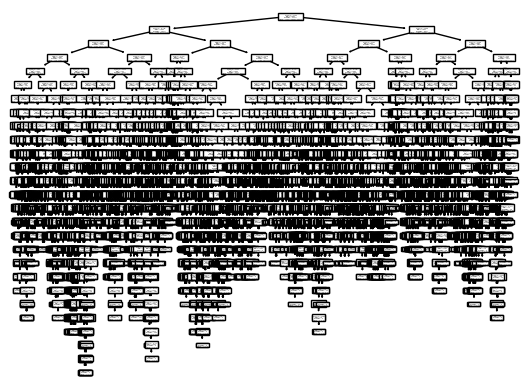

In [9]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)
decision_tree_classifier_predictions = decision_tree_classifier.predict(X_val)
plot_tree(decision_tree_classifier)
print(classification_report(y_val, decision_tree_classifier_predictions))

### [Extra tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html#extratreeclassifier)

              precision    recall  f1-score   support

           0       0.36      0.35      0.36      1556
           1       0.47      0.46      0.47      2248
           2       0.42      0.43      0.42      1691

    accuracy                           0.42      5495
   macro avg       0.42      0.42      0.42      5495
weighted avg       0.42      0.42      0.42      5495



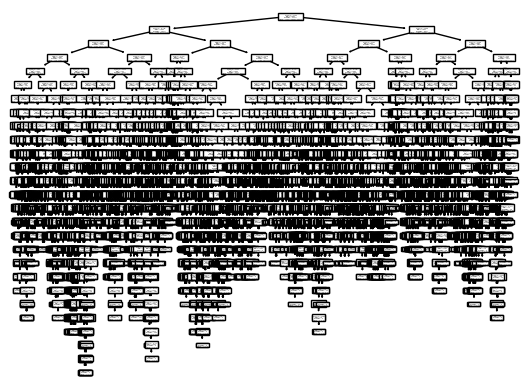

In [10]:
extra_tree_classifier = ExtraTreeClassifier()
extra_tree_classifier.fit(X_train, y_train)
extra_tree_classifier_predictions = extra_tree_classifier.predict(X_val)
plot_tree(decision_tree_classifier)
print(classification_report(y_val, extra_tree_classifier_predictions))

## [Ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html#ensembles-gradient-boosting-random-forests-bagging-voting-stacking)

[API reference](https://scikit-learn.org/stable/api/sklearn.ensemble.html)

### [Randomised tree ensembles](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles)

#### [Random forest classifier](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)

In [11]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train, y_train)
random_forest_classifier_predictions = random_forest_classifier.predict(X_val)
print(classification_report(y_val, random_forest_classifier_predictions))


              precision    recall  f1-score   support

           0       0.63      0.41      0.50      1556
           1       0.54      0.76      0.63      2248
           2       0.71      0.54      0.61      1691

    accuracy                           0.60      5495
   macro avg       0.63      0.57      0.58      5495
weighted avg       0.62      0.60      0.59      5495



#### [Extremely randomized trees classifier](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)

In [12]:
extra_trees_classifier = ExtraTreesClassifier()
extra_trees_classifier.fit(X_train, y_train)
extra_trees_classifier_predictions = extra_trees_classifier.predict(X_val)
print(classification_report(y_val, extra_trees_classifier_predictions))


              precision    recall  f1-score   support

           0       0.64      0.40      0.49      1556
           1       0.54      0.77      0.64      2248
           2       0.68      0.54      0.60      1691

    accuracy                           0.59      5495
   macro avg       0.62      0.57      0.58      5495
weighted avg       0.61      0.59      0.59      5495



### [Gradient boosted trees](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees)

#### [Gradient boosted decision trees](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees)

In [13]:
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train, y_train)
gradient_boosting_classifier_predictions = gradient_boosting_classifier.predict(X_val)
print(classification_report(y_val, gradient_boosting_classifier_predictions))


              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1556
           1       0.59      0.70      0.64      2248
           2       0.69      0.62      0.66      1691

    accuracy                           0.63      5495
   macro avg       0.64      0.62      0.63      5495
weighted avg       0.63      0.63      0.63      5495



#### [Histogram gradient boosted decision trees](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)

In [14]:
hist_gradient_boosting_classifier = HistGradientBoostingClassifier()
hist_gradient_boosting_classifier.fit(X_train, y_train)
hist_gradient_boosting_classifier_predictions = hist_gradient_boosting_classifier.predict(X_val)
print(classification_report(y_val, hist_gradient_boosting_classifier_predictions))

              precision    recall  f1-score   support

           0       0.64      0.56      0.59      1556
           1       0.60      0.69      0.64      2248
           2       0.71      0.65      0.68      1691

    accuracy                           0.64      5495
   macro avg       0.65      0.63      0.64      5495
weighted avg       0.64      0.64      0.64      5495



### Other combined methods

#### [Bagging meta estimator classifier](https://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator)

In [15]:
bagging_classifier = BaggingClassifier()
bagging_classifier.fit(X_train, y_train)
bagging_classifier_predictions = bagging_classifier.predict(X_val)
print(classification_report(y_val, bagging_classifier_predictions))

              precision    recall  f1-score   support

           0       0.47      0.48      0.47      1556
           1       0.51      0.57      0.54      2248
           2       0.60      0.49      0.54      1691

    accuracy                           0.52      5495
   macro avg       0.53      0.51      0.52      5495
weighted avg       0.53      0.52      0.52      5495



#### [Voting classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

In [16]:
voting_classifier = VotingClassifier(estimators=[("decision_tree", decision_tree_classifier),
                                                 ("extra_tree", extra_tree_classifier),
                                                 ("random_forest", random_forest_classifier),
                                                 ("extra_trees", extra_trees_classifier),
                                                 ("gradient_boosting", gradient_boosting_classifier),
                                                 ("hist_gradient_boosting", hist_gradient_boosting_classifier),
                                                 ("bagging", bagging_classifier)])
voting_classifier.fit(X_train, y_train)
vote_classifier_predictions = voting_classifier.predict(X_val)
print(classification_report(y_val, vote_classifier_predictions))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56      1556
           1       0.57      0.75      0.65      2248
           2       0.74      0.57      0.65      1691

    accuracy                           0.62      5495
   macro avg       0.65      0.61      0.62      5495
weighted avg       0.64      0.62      0.62      5495



#### [Stacked generalisation classifier](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization)

In [17]:
stacking_classifier = StackingClassifier(estimators=[("decision_tree", decision_tree_classifier),
                                                     ("extra_tree", extra_tree_classifier),
                                                     ("random_forest", random_forest_classifier),
                                                     ("extra_trees", extra_trees_classifier),
                                                     ("gradient_boosting", gradient_boosting_classifier),
                                                     ("hist_gradient_boosting", hist_gradient_boosting_classifier),
                                                     ("bagging", bagging_classifier)])
stacking_classifier.fit(X_train, y_train)
stacking_classifier_predictions = stacking_classifier.predict(X_val)
print(classification_report(y_val, stacking_classifier_predictions))

Processing train data:  23%|██▎       | 4983/21984 [1:24:12<4:47:17,  1.01s/it]


KeyboardInterrupt: 

#### [Isolation forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [18]:
isolated_forest_classifier = IsolationForest()
isolated_forest_classifier.fit(X_train)
isolated_forest_predictions = isolated_forest_classifier.predict(X_val)
print(classification_report(y_val, isolated_forest_predictions))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1556
           1       0.40      0.94      0.57      2248
           2       0.00      0.00      0.00      1691

    accuracy                           0.38      5495
   macro avg       0.10      0.23      0.14      5495
weighted avg       0.17      0.38      0.23      5495



/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w

### Advanced boosting algorithms

#### [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

In [19]:
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train, y_train)
adaboost_classifier_predictions = adaboost_classifier.predict(X_val)
print(classification_report(y_val, adaboost_classifier_predictions))

              precision    recall  f1-score   support

           0       0.54      0.42      0.47      1556
           1       0.53      0.63      0.57      2248
           2       0.60      0.58      0.59      1691

    accuracy                           0.55      5495
   macro avg       0.56      0.54      0.54      5495
weighted avg       0.55      0.55      0.55      5495



#### [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)

In [22]:
xgboost_classifier = XGBClassifier(tree_method="hist", device="cuda", n_jobs=-1)
xgboost_classifier.fit(X_train, y_train)
xgboost_classifier_predictions = xgboost_classifier.predict(X_val)
print(classification_report(y_val, xgboost_classifier_predictions))


              precision    recall  f1-score   support

           0       0.64      0.56      0.60      1556
           1       0.60      0.69      0.64      2248
           2       0.71      0.65      0.68      1691

    accuracy                           0.64      5495
   macro avg       0.65      0.63      0.64      5495
weighted avg       0.64      0.64      0.64      5495



#### [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

In [23]:
lightgbm_classifier = LGBMClassifier(device="gpu", n_jobs=-1)
lightgbm_classifier.fit(X_train, y_train)
lightgbm_classifier_predictions = lightgbm_classifier.predict(X_val)
print(classification_report(y_val, lightgbm_classifier_predictions))


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 21983, number of used features: 300
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (6.29 MB) transferred to GPU in 0.007587 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.261857
[LightGBM] [Info] Start training from score -0.907820
[LightGBM] [Info] Start training from score -1.160053
              precision    recall  f1-score   support

           0       0.64      0.56      0.60      1556
           1       0.60      0.70      0.65      2248
           2       0.71      0.65      0.68      1691

    accuracy                           0.64      5495
   macro avg       0.65      0.64      0.64      5495
weighted avg       0.65      0.64      0.64      5495



/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### [CatBoost](https://catboost.ai/docs/en/)

In [24]:
catboost_classifier = CatBoostClassifier(task_type="GPU")
catboost_classifier.fit(X_train, y_train)
catboost_classifier_predictions = catboost_classifier.predict(X_val)
print(classification_report(y_val, catboost_classifier_predictions))


Learning rate set to 0.121918
0:	learn: 1.0789075	total: 88.8ms	remaining: 1m 28s
1:	learn: 1.0630980	total: 106ms	remaining: 53.1s
2:	learn: 1.0482001	total: 124ms	remaining: 41.1s
3:	learn: 1.0354630	total: 141ms	remaining: 35s
4:	learn: 1.0244071	total: 157ms	remaining: 31.3s
5:	learn: 1.0143876	total: 175ms	remaining: 28.9s
6:	learn: 1.0048416	total: 191ms	remaining: 27.1s
7:	learn: 0.9961302	total: 208ms	remaining: 25.8s
8:	learn: 0.9881516	total: 225ms	remaining: 24.7s
9:	learn: 0.9803524	total: 240ms	remaining: 23.8s
10:	learn: 0.9732193	total: 252ms	remaining: 22.7s
11:	learn: 0.9670982	total: 265ms	remaining: 21.8s
12:	learn: 0.9610925	total: 278ms	remaining: 21.1s
13:	learn: 0.9554783	total: 291ms	remaining: 20.5s
14:	learn: 0.9500991	total: 303ms	remaining: 19.9s
15:	learn: 0.9451362	total: 316ms	remaining: 19.4s
16:	learn: 0.9400715	total: 329ms	remaining: 19s
17:	learn: 0.9356624	total: 341ms	remaining: 18.6s
18:	learn: 0.9310642	total: 354ms	remaining: 18.3s
19:	learn: 0.

#### [NGBoost](https://stanfordmlgroup.github.io/ngboost/intro.html)

In [25]:
ngboost_classifier = NGBClassifier()
ngboost_classifier.fit(X_train, y_train)
ngboost_classifier_predictions = ngboost_classifier.predict(X_val)
print(classification_report(y_val, ngboost_classifier_predictions))

IndexError: index 2 is out of bounds for axis 0 with size 2

## Load test data

In [ ]:
test_df = pd.read_csv("data/test_spacy_preprocessed.csv")
print("Test set size: " + str(len(test_df)))

# X_test = vectorizer.transform(test_set["lemmatized_sentence"])
# X_test = torch.Tensor(X_test.todense())

# Process test set using the GloVe embeddings
X_test = np.array([document_vector(doc.split(), glove_vectors) 
                  for doc in tqdm(test_df["lemmatized_sentence"], desc="Processing test data")])

X_test_standard_scaled = standard_scaler.transform(X_test)
X_test_min_max_scaled = min_max_scaler.transform(X_test)
X_test_binarized = binarizer.transform(X_test)

Test set size: 1032


Processing test data: 100%|██████████| 1032/1032 [00:00<00:00, 34821.50it/s]


## Evaluate models

In [ ]:
reverse_label_map = {
    0: -1,
    1: 0,
    2: 1
}

# decision_tree_classifier_predictions = decision_tree_classifier.predict(X_test)
# extra_tree_classifier_predictions = extra_tree_classifier.predict(X_test)
# random_forest_classifier_predictions = random_forest_classifier.predict(X_test)
# extra_trees_classifier_predictions = extra_trees_classifier.predict(X_test)
# gradient_boosting_classifier_predictions = gradient_boosting_classifier.predict(X_test)
# hist_gradient_boosting_classifier_predictions = hist_gradient_boosting_classifier.predict(X_test)
# bagging_classifier_predictions = bagging_classifier.predict(X_test)
# voting_classifier_predictions = voting_classifier.predict(X_test)
# stacking_classifier_predictions = stacking_classifier.predict(X_test)
# isolated_forest_predictions = isolated_forest_classifier.predict(X_test)
# adaboost_classifier_predictions = adaboost_classifier.predict(X_test)
# xgboost_classifier_predictions = xgboost_classifier.predict(X_test)
# lightgbm_classifier_predictions = lightgbm_classifier.predict(X_test)
# catboost_classifier_predictions = catboost_classifier.predict(X_test)
# ngboost_classifier_predictions = ngboost_classifier.predict(X_test)

predictions_to_save = gradient_boosting_classifier_predictions
mapped_predictions = np.array([reverse_label_map[prediction] for prediction in predictions_to_save])
predictions_df = pd.DataFrame({
    "sentence_id": test_df["Sentence_id"],
    "Verdict": mapped_predictions
})
predictions_df.to_csv("data/A2_BrannonAwXuWei_E0725283.csv", index=False)

predictions_df.head()

,sentence_id,Verdict
0,1,-1
1,2,1
2,3,-1
3,4,-1
4,5,1
